In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
import functools

src_path = os.path.abspath(os.path.join('../src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils.data import load_news, load_behaviors
from utils.hydra import RunCollection
from evaluation.metrics import gs_score, ild

DATA_DIR = "../data"
MIN_HISTORY_LENGTH = 3


In [ ]:
collection = RunCollection.from_path("../outputs")
collection = collection.filter_by_job("train_recommender")
runs = collection.filter_by_override("+experiment", "n_interest_vectors")
runs = runs.filter_by_config_value("seed", 704)


In [7]:
dev_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_dev.csv")).assign(run=run) for run in runs])
dev_metrics = dev_metrics.reset_index(drop=True)
test_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_test.csv")).assign(run=run) for run in runs])
test_metrics = test_metrics.reset_index(drop=True)
best_metrics = test_metrics.loc[dev_metrics.groupby("run")["AUC"].idxmax()]
best_metrics["n_interest_vectors"] = best_metrics["run"].apply(lambda run: run.config.model.user_encoder.n_interest_vectors)
best_metrics = best_metrics.sort_values("n_interest_vectors").set_index("n_interest_vectors")
multi_interest_metrics = best_metrics
multi_interest_metrics

,AUC,MRR,NDCG@5,NDCG@10,epoch,run
n_interest_vectors,,,,,,
1,0.664676,0.313873,0.346923,0.410967,5,Run(path=../outputs/2023-05-10/09-47-44.116210)
4,0.631665,0.291653,0.319251,0.384829,5,Run(path=../outputs/2023-05-10/09-47-44.111833)
8,0.631102,0.292746,0.320241,0.385510,4,Run(path=../outputs/2023-05-10/09-47-44.135950)
16,0.635264,0.294618,0.323092,0.388330,4,Run(path=../outputs/2023-05-10/09-47-47.453541)
32,0.648128,0.299631,0.329890,0.394363,4,Run(path=../outputs/2023-05-10/09-47-44.073541)


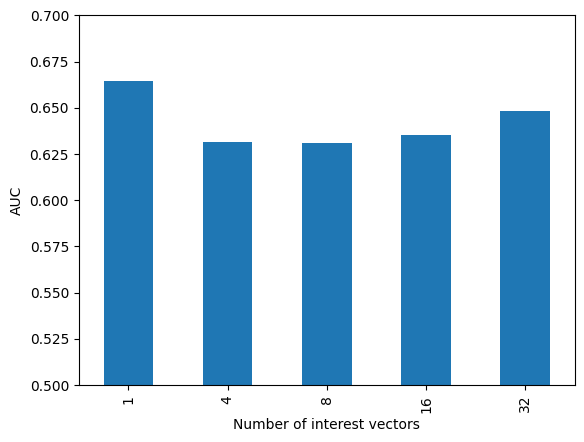

In [44]:
fig, ax = plt.subplots()
multi_interest_metrics["AUC"].plot.bar(ax=ax)
ax.set_ylim((0.5, 0.7))
ax.set_ylabel("AUC")
ax.set_xlabel("Number of interest vectors")
plt.show()

In [56]:
best_multi_interest_run = multi_interest_metrics.loc[multi_interest_metrics.drop(index=1)["AUC"].idxmax()].run
no_user_attention_run = collection.filter_by_override("+experiment", "no_user_attention").one()
# baseline_run = collection.filter_by_override("+experiment", "baseline").one()
baseline_run = multi_interest_metrics.loc[1].run

user_encoder_runs = {
    "Mean": no_user_attention_run,
    "Attention": baseline_run,
    "Multi-interest": best_multi_interest_run,
}
dev_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_dev.csv")).assign(user_encoder=user_encoder) for user_encoder, run in user_encoder_runs.items()])
dev_metrics = dev_metrics.reset_index(drop=True)
test_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_test.csv")).assign(user_encoder=user_encoder) for user_encoder, run in user_encoder_runs.items()])
test_metrics = test_metrics.reset_index(drop=True)
best_metrics = test_metrics.loc[dev_metrics.groupby("user_encoder")["AUC"].idxmax()]
best_metrics = best_metrics.set_index("user_encoder", drop=True)
user_encoder_metrics = best_metrics
user_encoder_metrics


,AUC,MRR,NDCG@5,NDCG@10,epoch
user_encoder,,,,,
Attention,0.664676,0.313873,0.346923,0.410967,5
Mean,0.657101,0.310959,0.342026,0.406962,5
Multi-interest,0.648128,0.299631,0.329890,0.394363,4


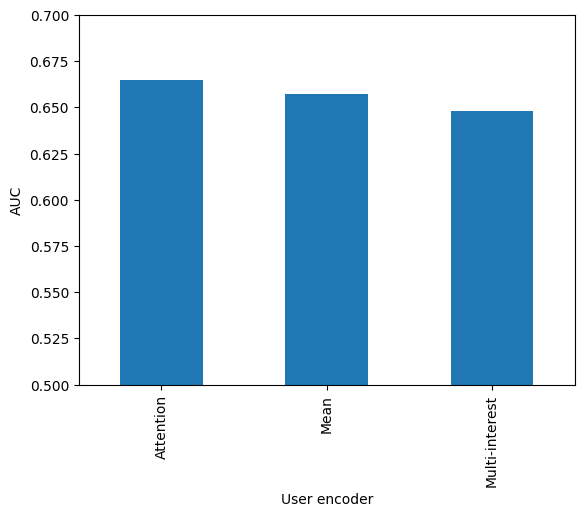

In [57]:
fig, ax = plt.subplots()
user_encoder_metrics["AUC"].plot.bar(ax=ax)
ax.set_ylim((0.5, 0.7))
ax.set_ylabel("AUC")
ax.set_xlabel("User encoder")
plt.show()

In [76]:
mind_variant = list(user_encoder_runs.values())[0].config.mind_variant
news = load_news(mind_variant, columns=["category", "subcategory", "title"], data_dir=DATA_DIR)
news = news.drop(columns="split")
news

,category,subcategory,title
id,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an..."
N23144,health,weightloss,50 Worst Habits For Belly Fat
N86255,health,medical,Dispose of unwanted prescription drugs during ...
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...
...,...,...,...
N8607,news,newsgoodnews,"Monroe boy, 11, called 'hero' for calling 911,..."
N130348,autos,autosnews,Virgin Trains construction to close downtown M...
N41349,news,newspolitics,Analysis: Trump's core impeachment defense suf...


In [77]:
runs = RunCollection.from_path("../outputs")
runs = runs.filter_by_job("train_embeddings")
run = runs.one()
metrics = pd.read_csv(run.get_file_path("metrics.csv"))
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
news = news.reset_index().merge(topic_embeddings, on="subcategory")
news = news.set_index("id")
news

Using topic embeddings from epoch 3


,category,subcategory,title,embedding
id,,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N81543,lifestyle,lifestyleroyals,Kate Middleton's Best Hairstyles Through the Y...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N71593,lifestyle,lifestyleroyals,Every outfit Duchess Kate has worn in 2019,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N33576,lifestyle,lifestyleroyals,25 Photos of the Royal Family at Balmoral Cast...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N115791,lifestyle,lifestyleroyals,Prince George's Royal Life in Photos,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
...,...,...,...,...
N53304,lifestyle,relationships,Want to Plan the Best Christmas Proposal Ever?...,"[1.4300101, -0.51480174, 1.3971273, 0.66752815..."
N99911,autos,autosconvertibles,2020 Chevrolet Corvette C8 Convertible Price S...,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,..."
N61853,sports,olympics-videos,NBA head to travel to China amid flap over pro...,"[-0.3969354, -0.6827047, -1.0807043, -0.829718..."


In [137]:
behaviors = load_behaviors(mind_variant, ["test"], data_dir="../data")
behaviors["impression_ids"] = behaviors.impressions.apply(lambda impressions: [x.split("-")[0] for x in impressions])
behaviors["clicked"] = behaviors.impressions.apply(lambda impressions: [int(x.split("-")[1]) for x in impressions])
behaviors = behaviors.drop(columns=["time", "impressions", "split"])
behaviors = behaviors.set_index("log_id")
behaviors

,user,history,impression_ids,clicked
log_id,,,,
9,U114779,"[N14678, N35786, N91030, N76664, N40228, N4786...","[N21018, N89764, N46641, N58760, N2110, N18468...","[0, 0, 0, 0, 0, 1, 0]"
23,U386485,"[N112642, N84454, N22660]","[N126404, N9989, N76539, N112378, N82573, N339...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25,U287749,"[N10263, N65119, N81899, N4289, N49685, N46994...","[N55801, N29160, N82503, N18190, N54368]","[0, 0, 0, 0, 1]"
38,U714431,"[N25197, N107441, N72135, N93987, N112751, N97...","[N73833, N18468, N54900, N33901, N42208, N1227...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
47,U78193,"[N62519, N100420, N3113, N9818, N62519, N98108...","[N53018, N34044, N117802, N120089, N29160, N89...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
376445,U267670,"[N98156, N85484, N87763, N1596, N1713, N126027...","[N119999, N29160, N48476, N66180, N23452, N302...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
376451,U443369,"[N94492, N84454]","[N17038, N21018, N40742, N3623, N52388, N28518...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
376456,U468320,"[N35797, N20311, N120986, N128643, N85005, N59...","[N46555, N21018, N119999, N46641, N129416, N99...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [158]:
users = behaviors.drop_duplicates(subset="user").set_index("user")
users = users.drop(columns=["impression_ids", "clicked"])
users["history_length"] = users["history"].apply(len)
users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()
users


,history,history_length
user,,
U114779,"[N14678, N35786, N91030, N76664, N40228, N4786...",25
U386485,"[N112642, N84454, N22660]",3
U287749,"[N10263, N65119, N81899, N4289, N49685, N46994...",16
U714431,"[N25197, N107441, N72135, N93987, N112751, N97...",25
U78193,"[N62519, N100420, N3113, N9818, N62519, N98108...",27
...,...,...
U219442,"[N64593, N71922, N49900, N82405, N7553, N11698...",9
U573414,"[N65119, N72571, N123931, N94295, N46069, N624...",16
U267670,"[N98156, N85484, N87763, N1596, N1713, N126027...",8


In [165]:
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history.groupby("user")
users["GS"] = user_reads.apply(lambda x: gs_score(list(x["embedding"].values)) if len(x) > 1 else None)
users["GS percentile"] = pd.qcut(users["GS"], np.linspace(0, 1, 6), labels=np.arange(1, 6)/5)
users

,history,history_length,GS,GS percentile
user,,,,
U114779,"[N14678, N35786, N91030, N76664, N40228, N4786...",25,0.604681,1.0
U386485,"[N112642, N84454, N22660]",3,0.743455,1.0
U287749,"[N10263, N65119, N81899, N4289, N49685, N46994...",16,0.574057,0.8
U714431,"[N25197, N107441, N72135, N93987, N112751, N97...",25,0.518205,0.6
U78193,"[N62519, N100420, N3113, N9818, N62519, N98108...",27,0.541209,0.8
...,...,...,...,...
U219442,"[N64593, N71922, N49900, N82405, N7553, N11698...",9,0.556134,0.8
U573414,"[N65119, N72571, N123931, N94295, N46069, N624...",16,0.562316,0.8
U267670,"[N98156, N85484, N87763, N1596, N1713, N126027...",8,0.441913,0.2


In [166]:
results = {}
for user_encoder, run in user_encoder_runs.items():
    best_epoch = user_encoder_metrics.loc[user_encoder].epoch
    predictions = pd.read_feather(run.get_file_path(f"probs_{int(best_epoch)}_test.feather"))
    result = behaviors.merge(predictions, on="log_id")
    results[user_encoder] = result
    
results = pd.concat([result.assign(user_encoder=user_encoder) for user_encoder, result in results.items()])
results["AUC"] = results.apply(lambda row: roc_auc_score(row.clicked, row.probs), axis=1)
results

,log_id,user,history,impression_ids,clicked,probs,user_encoder,AUC
0,9,U114779,"[N14678, N35786, N91030, N76664, N40228, N4786...","[N21018, N89764, N46641, N58760, N2110, N18468...","[0, 0, 0, 0, 0, 1, 0]","[2.497229814529419, 3.371687412261963, 3.94730...",Mean,0.666667
1,23,U386485,"[N112642, N84454, N22660]","[N126404, N9989, N76539, N112378, N82573, N339...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2152944803237915, 0.138191819190979, 0.2577...",Mean,0.759542
2,25,U287749,"[N10263, N65119, N81899, N4289, N49685, N46994...","[N55801, N29160, N82503, N18190, N54368]","[0, 0, 0, 0, 1]","[1.4424784183502197, 2.2996411323547363, 1.617...",Mean,0.750000
3,38,U714431,"[N25197, N107441, N72135, N93987, N112751, N97...","[N73833, N18468, N54900, N33901, N42208, N1227...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.7671821117401123, 1.8830585479736328, 1.978...",Mean,0.700549
4,47,U78193,"[N62519, N100420, N3113, N9818, N62519, N98108...","[N53018, N34044, N117802, N120089, N29160, N89...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1.7116717100143433, 2.3507533073425293, 2.342...",Mean,0.200000
...,...,...,...,...,...,...,...,...
50073,376445,U267670,"[N98156, N85484, N87763, N1596, N1713, N126027...","[N119999, N29160, N48476, N66180, N23452, N302...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.43228039145469666, 2.0959272384643555, 0.15...",Multi-interest,0.660714
50074,376451,U443369,"[N94492, N84454]","[N17038, N21018, N40742, N3623, N52388, N28518...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.7105875015258789, 0.3183874785900116, 1.280...",Multi-interest,0.428571
50075,376456,U468320,"[N35797, N20311, N120986, N128643, N85005, N59...","[N46555, N21018, N119999, N46641, N129416, N99...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1.2184087038040161, 0.797775387763977, 1.0575...",Multi-interest,0.600000
50076,376460,U57138,"[N54656, N124051, N128643, N64496, N24738, N61...","[N29160, N119999, N46641, N89764, N117802, N21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[2.2926294803619385, 0.7234910130500793, 1.410...",Multi-interest,0.333333


In [167]:
averaged_per_user = results.groupby(["user_encoder", "user"]).AUC.mean().to_frame()
averaged_per_user = averaged_per_user.reset_index()
averaged_per_user

,user_encoder,user,AUC
0,Attention,U100017,0.600000
1,Attention,U100046,0.750000
2,Attention,U10005,0.530000
3,Attention,U100057,0.878701
4,Attention,U100070,0.539292
...,...,...,...
120256,Multi-interest,U99843,0.756250
120257,Multi-interest,U9985,0.775000
120258,Multi-interest,U99878,0.816479
120259,Multi-interest,U999,0.000000


In [168]:
averaged_per_user = averaged_per_user.merge(users, left_on="user", right_index=True)
averaged_per_user

,user_encoder,user,AUC,history,history_length,GS,GS percentile
0,Attention,U100017,0.600000,"[N29136, N39049, N43397, N89611, N128965, N162...",27,0.447744,0.2
40087,Mean,U100017,0.600000,"[N29136, N39049, N43397, N89611, N128965, N162...",27,0.447744,0.2
80174,Multi-interest,U100017,0.500000,"[N29136, N39049, N43397, N89611, N128965, N162...",27,0.447744,0.2
1,Attention,U100046,0.750000,"[N73947, N18389, N123633, N55903, N454, N67127...",24,0.510879,0.6
40088,Mean,U100046,0.600000,"[N73947, N18389, N123633, N55903, N454, N67127...",24,0.510879,0.6
...,...,...,...,...,...,...,...
80172,Mean,U999,0.000000,"[N122772, N32720, N35797, N122047, N110755, N5...",103,0.499968,0.6
120259,Multi-interest,U999,0.000000,"[N122772, N32720, N35797, N122047, N110755, N5...",103,0.499968,0.6
40086,Attention,U99959,0.538462,"[N477, N77566, N72590, N537, N49704, N8527, N8...",35,0.430040,0.2
80173,Mean,U99959,0.576923,"[N477, N77566, N72590, N537, N49704, N8527, N8...",35,0.430040,0.2


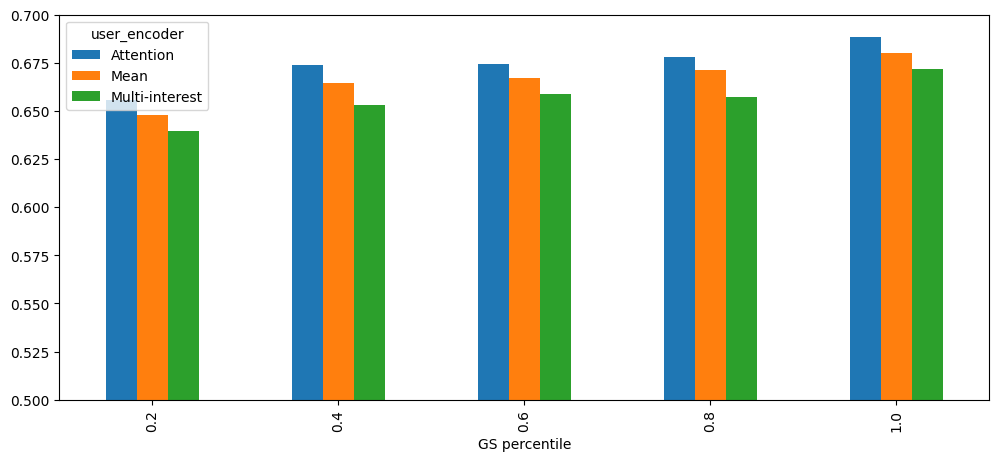

In [169]:
averaged = averaged_per_user.groupby(["user_encoder", "GS percentile"]).agg(AUC=("AUC", "mean"))
plot_data = averaged.stack().unstack(level=0).reset_index(level=1, drop=True)

fig, ax = plt.subplots(figsize=(12, 5))
ax = plot_data.plot.bar(ax=ax)
ax.set_ylim((0.5, 0.7))
plt.show()